In [81]:
import numpy as np
import sys
from random import seed, randint
import matplotlib.pyplot as plt
from math import isclose
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

## Ready Functions

Below cell's functions have been taken from the MMI513_week3.jpynb file. I have changed nothing in the functions. I tried to transport only the ones I needed.

## ChatGPT

I didn't use any ChatGPT assistance for the code I wrote. I only took help when adding more explainable comments to my code.

In [86]:

def lcg(modulus, a, c, seed):
    seed = (a * seed + c) % modulus
    return seed

def morton(Z, b=None):
    m = 1 # Left shifting bit mask
    n = len(Z)
    S = np.arange(n)
    if b==None:
        assert (Z>=0).all() # Check if all elements are non-negative
        numbitsmin = bitsrequired(np.min(Z))
        numbitsmax = bitsrequired(np.max(Z))
        b = max(numbitsmin, numbitsmax)
    r = 0
    for c in range(b): # Repeat b times
        for ind in range(n):
            r = r | ((Z[ind] & m) << S[ind])
            S[ind] += (n - 1)
        m = m << 1
    return r

def bitsrequired(n):
    if n==0:
        numbits = 1
    else:
        n = abs(n)
        numbits = int(1 + np.floor( np.log2( n + 1 ) ))
    return numbits

def unitlerp(a0, a1, t):
    # Linear interpolation with mixin weight, t
    assert(t >= 0 and t <= 1)
    return a0 * ( 1 - t ) + a1 * t

def clamp(mn, mx, val):
    if val<mn:
        val = mn
    elif val>mx:
        val = mx
    return val

def valueinterpolation1(a0, a1, t, infun):
    return unitlerp(a0, a1, infun(t))

def smootherstep(t):
    assert (t<=1) and (t>=0)
    val = 6 * t**5 - 15 * t**4 + 10*t**3
    if val > 1:
        return 1
    elif val < 0:
        return 0
    else:
        return 6 * t**5 - 15 * t**4 + 10*t**3


def positioninunitcircle():
    while True:
        x = 2 * np.random.rand() - 1
        y = 2 * np.random.rand() - 1
        s = x**2 + y**2
        if s>0 and s<1:
            break
    return x, y, s


def randomonunitsphere(numdim, seed):
    np.random.seed(seed)
    d = numdim
    R = np.zeros(numdim)
    xi = 0
    while 2<=d:
        d -= 2
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[d] = 0
            R[d + 1] = 0
        else:
            q = -2 * np.log(s)
            xi += q
            c = np.sqrt(q/s)
            R[d] = x * c
            R[d + 1] = y * c
    if d==1:
        x, y, s = positioninunitcircle()
        if isclose(s,0):
            R[0] = 0
        else:
            R[0] = x * np.sqrt(-2 * np.log(s) / s)
            xi += R[0]**2
    if isclose(xi, 0):
        return randomonunitsphere(numdim)
    R /= np.sqrt(xi)
    return R

def noiserandomvector(N, n):
    seed = morton(N)
    R = randomonunitsphere(n, seed)
    return R

def noiseperlin(x, y):
    assert x>=0 and y>=0
    xw = np.floor(x)
    yw = np.floor(y)
    xf = x - xw
    yf = y - yw
    a00 = noiserandomvector(np.array([xw, yw], np.int32), 2)
    a10 = noiserandomvector(np.array([xw + 1, yw], np.int32), 2)
    a01 = noiserandomvector(np.array([xw, yw + 1], np.int32), 2)
    a11 = noiserandomvector(np.array([xw + 1, yw + 1], np.int32), 2)
    pt = np.array([x, y])
    v00 = pt - np.array([xw, yw])
    v10 = pt - np.array([xw + 1, yw])
    v01 = pt - np.array([xw, yw + 1])
    v11 = pt - np.array([xw + 1, yw + 1])
    d00 = np.sum(a00 * v00)
    d01 = np.sum(a01 * v01)
    d10 = np.sum(a10 * v10)
    d11 = np.sum(a11 * v11)
    ds0 = valueinterpolation1(d00, d10, xf, smootherstep)
    ds1 = valueinterpolation1(d01, d11, xf, smootherstep)
    val = valueinterpolation1(ds0, ds1, yf, smootherstep)
    return val


In [70]:
def ramp(r):
    """
    This function calculates the ramp function used in the constrained function.
    If the input value is greater than or equal to 1, it returns 1.
    If the input value is between -1 and 1, it returns a function of that input value using a polynomial expression.
    If the input value is less than or equal to -1, it returns -1.
    """
    if r >= 1:
        return 1
    elif r > -1:
        return ( (15/8) * r  - (10/8) * r**3 + (3/8) * r**5)
    else:
        return -1 


def findMinofFour(x,y,h,w):
    """
    This function finds the minimum distance between the point (x, y) and the edges of a rectangle of size (h, w).
    It then returns that minimum distance with its sign.
    """
    if (min(abs(x-w),x) < min(abs(y-h),y)) :
        if abs(x-w) < x:
            return w-x
        else: return x
    else:
        if abs(y-h) < y:
            return h-y
        else: return y


def constrained(x,y,h,w):
    """
    This function calculates the constrained function using the ramp and findMinofFour functions.
    It takes the input (x, y) and rectangle size (h, w), and returns a value that is a product of a noise function and the ramp function applied to the minimum distance of the input point from the rectangle edges.
    """
    minVal = findMinofFour(x,y,h,w)
    psi = noiseperlin(x, y)  # This function is not defined in the provided code and should be imported or defined elsewhere
    return psi*ramp(minVal)
    

def differentiation(x,y,h,w):    
    """
    This function calculates the partial derivatives of the constrained function with respect to x and y at the point (x, y).
    It does this by approximating the function using the difference quotient with a small step size of 1e-4.
    """
    withoutStep = constrained(x,y,h,w)

    with_x, with_y = constrained(x + 1e-4, y, h, w), constrained(x, 1e-4 + y, h, w)

    respectToX = (with_x - withoutStep) / 1e-4
    respectToY = (with_y - withoutStep) / 1e-4

    return respectToY, -respectToX


def curlNoise(h, w, instances):
    """
    This function takes the old positions of a set of particles represented by instances and returns their new positions.
    It does this by computing the partial derivatives of the constrained function with respect to x and y at the current particle position.
    It then updates the particle position using a scaled version of the derivatives as the new velocity.
    If the new position is outside the bounds of the rectangle, it sets it to the boundary.
    """
    res = []
    for i,(x,y) in enumerate(instances):
        vecX, vecY = differentiation(x,y,h,w)

        newX, newY = x + vecX*0.1, y + vecY*0.1

        if newX <0 : newX = 0
        if newY <0 : newY = 0

        res.append(np.array([newX,newY]))

    return np.array(res)


## Velocity Vector Fields

Now we have everything to proceed, but first lets check that if we can get pretty vector fields using noiseperlin.

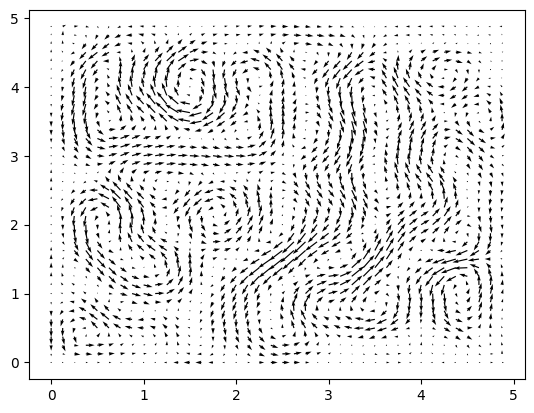

In [75]:
def createFields(h,w,pointsToLookForVectors):
    # Initialize empty arrays to hold x and y components of the vector fields and indices of the points
    ux = []
    uy = []
    ind = []

    # Loop over the grid of points to extract vectors and their corresponding indices
    for i in np.arange(0,w,w/pointsToLookForVectors):
        for j in np.arange(0,w,w/pointsToLookForVectors):
            # Append the x and y components of the vector at point (i, j) to their respective arrays
            ux.append(np.array(differentiation(i,j,h,w)[0]))
            uy.append(np.array(differentiation(i,j,h,w)[1]))
            # Append the index (i,j) to the array holding all the indices
            ind.append(np.array([i,j]))

    # Convert the list of indices to a numpy array
    ind = np.array(ind)

    # Separate the x and y components of the indices
    (x,y) = ind[:,0],ind[:,1]
    # Assign the x and y components of the vectors to the variables u and v, respectively
    u = ux
    v = uy
    # Return the x and y components of the indices, and the x and y components of the vectors
    return x,y,u,v

h = 5 
w = 5 
pointsToLookForVectors = 40

# Call the createFields function and extract the returned values
x,y,u,v = createFields(h,w,pointsToLookForVectors)
# Plot the vector field using matplotlib's quiver function
plt.quiver(x,y,u,v)
plt.show()


## Animation 

Below animation class is inspired from a code online, I changed it pretty much for my purposes. It does nothing other than creating the velocity fields to the background, and then gets the particules' next positions frame by frame.

In [88]:
class AnimatedScatter(object):
    def __init__(self, pointsToLookForVectors, h, w, myArray, numpoints=50):
        """
        Initialize an instance of the AnimatedScatter class.

        Arguments:
        - pointsToLookForVectors: int, specifies how many points to use when creating the vector field.
        - h: int, height of the field.
        - w: int, width of the field.
        - myArray: numpy array of shape (n, 2), initial positions of the particles.
        - numpoints: int, number of particles to display.
        """
        self.numpoints = numpoints

        self.h = h
        self.w = w

        # Create a figure and axes for the plot, and set the axis limits.
        self.fig, self.ax = plt.subplots()
        self.ax.axis([-0.5, h+0.5, -0.5, w+0.5])

        # Create a vector field using the createFields function.
        x,y,u,v = createFields(h,w,pointsToLookForVectors+10)

        # Plot the vector field using the quiver function.
        plt.quiver(x,y,u,v,alpha=0.5)

        # Store the particle positions in the particules attribute.
        self.particules = myArray

        # Create a scatter plot of the particles using the scatter function.
        self.scat = self.ax.scatter(myArray[:,0], myArray[:,1], c="r", s=14, edgecolor="k")

        # Create an animation using the FuncAnimation class and the update method defined below.
        self.ani = FuncAnimation(self.fig, self.update, frames=300, interval=50, blit=True)

        # Close the plot window to avoid showing it when the animate method is called.
        plt.close()

    def update(self,frame):
        """
        Update the particle positions and return the updated scatter plot.

        Arguments:
        - frame: int, the current frame number (not used in this method).

        Returns:
        - a list containing the updated scatter plot.
        """
        global myArray

        # Update the scatter plot with the new particle positions.
        self.scat.set_offsets(self.particules)

        # Update the particle positions using the curlNoise function.
        self.particules = curlNoise(self.h, self.w, self.particules)

        # Return the updated scatter plot.
        return [self.scat]

    def animate(self):
        """
        Create an HTML5 video of the animation.

        Returns:
        - an HTML object containing the video.
        """
        return HTML(self.ani.to_html5_video())


In [89]:
def test():
    # Initialize an empty list to hold particle positions
    arr = []

    # Set the number of particles to be created
    particulenumber = 20

    # Set the height and width of the field
    h = 5
    w = 5

    # Loop through each point on a grid of size particlenumber x particlenumber
    for i in np.arange(0,w,w/particulenumber):
        for j in np.arange(0,h,h/particulenumber):
            # Create a numpy array containing the x and y position of each particle
            arr.append(np.array([i,j]))

    # Convert the list of particle positions into a numpy array
    myArray = np.array(arr)

    # Create an instance of the AnimatedScatter class with the specified parameters
    a = AnimatedScatter(particulenumber,h,w,myArray)
    
    # Call the animate method of the AnimatedScatter instance to generate and display the animation
    return a.animate()

# Call the test function to run the code
test()
